# Preprocessing and building a simple ML pipeline

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

<br><br>

## Step 1: Introducing the dataset <a name="1"></a>
<hr>

In this notebook, I will work on [the adult census dataset](https://www.kaggle.com/uciml/adult-census-income#) from Kaggle dataset. I downloaded the CSV and saved it as `adult.csv` locally in this folder. 

This is a classification dataset and the classification task is to predict whether income exceeds 50K per year or not based on the census data. More information on the dataset and features can be found [here](http://archive.ics.uci.edu/ml/datasets/Adult).

The starter code below loads the data CSV (assuming that it is saved as `adult.csv` in this folder). 

> Note that many popular datasets have sex as a feature where the possible values are male and female. This representation reflects how the data were collected and is not meant to imply that, for example, gender is binary.

In [2]:
census_df = pd.read_csv("adult.csv")
census_df.shape

(32561, 15)

<br><br>

### 1.1 Data splitting 

In order to avoid violation of the golden rule, the first step before we do anything is splitting the data. 

I split the data into `train_df` (60%) and `test_df` (40%) with `random_state = 42`. I keep the target column (`income`) in the splits so that I can use it in the exploratory data analysis.   

In [3]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

## Step 2: Exploratory data analysis (EDA) <a name="2"></a> 
<hr>

Let's examine our `train_df`. 

In [4]:
train_df.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


We see some missing values represented with a "?". Probably these were the questions not answered by some people during the census.  Usually `.describe()` or `.info()` methods would give you information on missing values. But here, they won't pick "?" as missing values as they are encoded as strings instead of an actual NaN in Python. So let's replace them with `np.nan` before we carry out EDA. If you do not do it, you'll encounter an error later on when you try to pass this data to a classifier. 

In [5]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [6]:
train_df_nan.sort_index()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,NaN,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32553,43,Private,84661,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,<=50K
32554,32,Private,116138,Masters,14,Never-married,Tech-support,Not-in-family,Asian-Pac-Islander,Male,0,0,11,Taiwan,<=50K
32555,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K


The "?" symbols are now replaced with NaN values. 

<br><br>

### 2.1 Visualizing features

First, I examine the information given by `train_df_nan.info()` and `train_df_nan.describe()` methods. In case of `.describe()`, I use the `include="all"` argument to show summary statistics of all features.

> Note: It's also welcomed to use [`pandas_profiling`](https://github.com/pandas-profiling/pandas-profiling) for more elaborate visualization and EDA.

In [7]:
from pandas_profiling import ProfileReport

# profile = ProfileReport(train_df_nan, title="Pandas Profiling Report")  # , minimal=True)

# profile.to_notebook_iframe()

In [8]:
train_df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19536 entries, 25823 to 23654
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             19536 non-null  int64 
 1   workclass       18428 non-null  object
 2   fnlwgt          19536 non-null  int64 
 3   education       19536 non-null  object
 4   education.num   19536 non-null  int64 
 5   marital.status  19536 non-null  object
 6   occupation      18424 non-null  object
 7   relationship    19536 non-null  object
 8   race            19536 non-null  object
 9   sex             19536 non-null  object
 10  capital.gain    19536 non-null  int64 
 11  capital.loss    19536 non-null  int64 
 12  hours.per.week  19536 non-null  int64 
 13  native.country  19187 non-null  object
 14  income          19536 non-null  object
dtypes: int64(6), object(9)
memory usage: 2.4+ MB


In [9]:
train_df_nan.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,19536.000000,1.953600e+04,19536.000000,19536.000000,19536.000000,19536.000000
mean,38.592547,1.892662e+05,10.084767,1090.443540,86.537162,40.532606
std,13.638971,1.049020e+05,2.580723,7449.700833,402.395668,12.406636
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.177670e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.782835e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.368860e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.455435e+06,16.000000,99999.000000,4356.000000,99.000000


Then I visualize the histograms of four numeric features. 

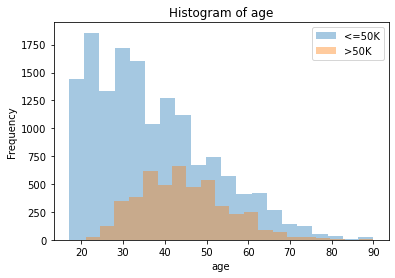

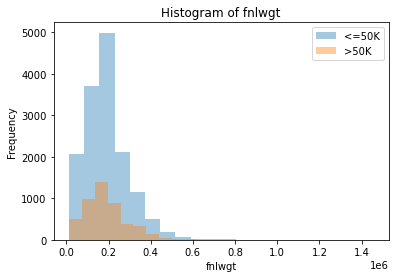

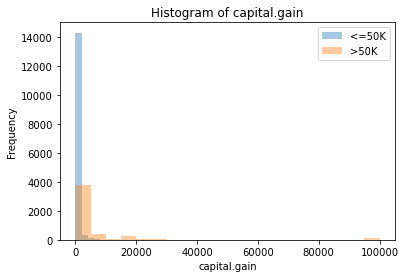

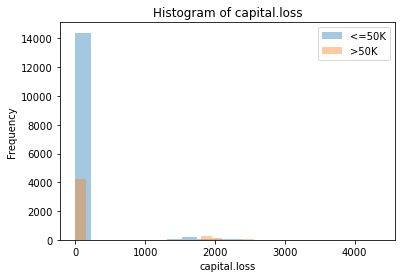

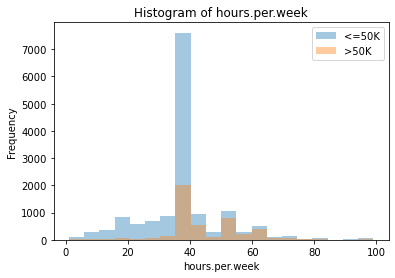

In [10]:
numeric_features = [
    "age",
    "fnlwgt",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]
for feat in numeric_features:
    ax = train_df_nan.groupby("income")[feat].plot.hist(bins=20, alpha=0.4, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

Age feature seem to be a promising feature. 

<br><br>

### 2.2 Identify transformations to apply

| Feature | Transformation |
| --- | ----------- |
| age | scaling |
| workclass | imputation, OHE |
| fnlwgt | scaling |
| education | OHE |
| education.num | scaling |
| marital.status | OHE  |
| occupation | imputation, OHE  |
| relationship | OHE  |
| race | OHE  |
| sex | OHE  |
| capital.gain | scaling |
| capital.loss | scaling |
| hours.per.week | scaling |
| native.country | imputation, OHE |

It's fine to apply imputation for all features to make things simpler. Also it's a good strategy to deal with missing values in test data.  

> Note: OHE stands for One-Hot-Encoding, and imputation means dealing with missing data.

<br><br>

### 2.3 Feature types 

Here I would like to identify some common transformations I would like to apply on certain types of features. 

In [12]:
# Let's identify numeric and categorical features

numeric_features = [
    "age",
    "fnlwgt",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    # "race",
    "native.country",
]

ordinal_features = ["education"]
binary_features = [
    "sex"
]  # Not binary in general but in this particular dataset it seems to have only two possible values
drop_features = ["education.num"]
target = "income"

In [13]:
train_df["education"].unique()

array(['7th-8th', 'Assoc-voc', 'HS-grad', 'Bachelors', 'Some-college',
       '10th', '11th', 'Prof-school', '12th', '5th-6th', 'Masters',
       'Assoc-acdm', '9th', 'Doctorate', '1st-4th', 'Preschool'],
      dtype=object)

In [14]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [15]:
assert set(education_levels) == set(train_df["education"].unique())

<br><br>

### 2.4 Race feature

**Something to be considered:**

Is including the `race` feature for predicting income ethically a good idea for this prediction problem? 


For me, this is entirely context dependent. But in general I would be cautious about including the race feature to predict income. Such systems get used in applications which can affect real people. For example, this prediction might be used in deciding whether to approve a loan application or not. Influencing this decision by race feature might harm people belonging to certain race.  

<br><br>

### 2.5 Separating feature vectors and targets  

In [16]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

However, at this point, we **cannot** train [`sklearn`'s `SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on `X_train` and `y_train`, because our data is not preprocessed yet; we have some categorical columns and some NaN values in numeric columns. We need to preprocess it first before feeding it into ML algorithms.

<br><br><br><br>

## Step 3: Preprocessing <a name="3"></a>
<hr> 

### 3.1 Scaling and one-hot encoding **without** `sklearn.pipeline.Pipeline`   

1. Apply scaling on `numeric_features` using [`scikit-learn`'s `StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). 
2. Apply imputation on `categorical_features` using [`scikit-learn`'s `SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to impute `NaN` values by a constant string "missing". 
3. Apply one-hot encoding on the imputed categorical features  from the previous question using [`scikit-learn`'s `OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).  

In [17]:
# Scale numeric features
scaler = StandardScaler()
X_num_train = scaler.fit_transform(X_train[numeric_features])
X_num_test = scaler.transform(X_test[numeric_features])

In [18]:
# Impute categorical missing values by a constant string
imp = SimpleImputer(strategy="constant", fill_value="missing")
X_cat_train = imp.fit_transform(X_train[categorical_features])
X_cat_test = imp.transform(X_test[categorical_features])

In [19]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_imp_ohe_train = ohe.fit_transform(X_cat_train)
X_imp_ohe_test = ohe.transform(X_cat_test)
ohe.get_feature_names(categorical_features)

array(['workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'workclass_missing', 'marital.status_Divorced',
       'marital.status_Married-AF-spouse',
       'marital.status_Married-civ-spouse',
       'marital.status_Married-spouse-absent',
       'marital.status_Never-married', 'marital.status_Separated',
       'marital.status_Widowed', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'occupation_missing',
       'relat

<br><br>

### 3.2 Visualization of transformed features 

1. Create preprocessed train split `X_train_pp` and test split `X_test_pp`, by horizontally stacking the transformed (i.e., scaled) numeric columns and transformed (i.e., imputed and one-hot encoded) categorical columns. 
2. Visualize the transformed data as a dataframe, with the appropriate column names. 

In [20]:
X_train_pp = None
X_test_pp = None

In [21]:
X_train_pp = np.hstack((X_num_train, X_imp_ohe_train))
X_test_pp = np.hstack((X_num_test, X_imp_ohe_test))

In [22]:
feature_names = numeric_features + ohe.get_feature_names(categorical_features).tolist()

In [23]:
X_train_pp = pd.DataFrame(
    data=X_train_pp,
    columns=feature_names,
    index=X_train.index,
)
X_train_pp

,age,fnlwgt,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia,native.country_missing
25823,-0.190089,0.536275,-0.146378,-0.215060,-0.445951,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10274,-0.923301,-0.524114,-0.146378,-0.215060,-0.445951,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
27652,-0.996622,-0.760159,-0.146378,-0.215060,-0.204138,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13941,-1.143264,-0.552827,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
31384,-0.849979,0.036757,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,-0.996622,2.106533,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5390,0.909729,-0.405142,-0.146378,-0.215060,-0.042930,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
860,1.203014,0.466408,-0.146378,4.474474,-0.042930,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
15795,0.176517,-0.335466,-0.146378,-0.215060,0.763111,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<br><br>

### 3.3 Cross-validation with the transformed data (Not to break the golden rule!)

If I carry out cross-validation using `cross_validate` on the preprocessed `X_train_pp` and `y_train`, as shown below, it would be violating the golden rule. 

```
knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train_pp, y_train, return_train_score=True)
```


We are breaking the golden rule here when we call `cross-validate` on preprocessed `X_train` and `y_train`. When carrying out preprocessing, we should apply `fit_transform` on the train split and only `transform` on the test split. If we pass preprocessed `X_train` to cross validation, the training phase would have some influence from the validation set. So we are subtly breaking the golden rule here. 

<br><br>

### 3.4 Preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`

Generally speaking, compared with carrying out transformations by hand, we want to carry out preprocessing using `sklearn`'s `ColumnTransformer` and `Pipeline`. 

- by using [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and explicitly providing named steps
- by using [`make_pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline), which automatically names the steps in the pipeline with their class names. 

Similarly we can create a column transformer in two ways:
- by using [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)
- by using [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) 

I would be using `make_pipeline` and `make_column_transformer`.  


In [24]:
preprocessor = None

In [25]:
numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [26]:
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['age', 'fnlwgt', 'capital.gain',
                                  'capital.loss', 'hours.per.week']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Preschool',
                                                             '1st-4th',
                                                             '5th-6th',
                                                             '7th-8th', '9th',
                                                             '10th', '11th',
                                                             '12th', 'HS-grad',
                                                             'Prof-school',
                                                             'Assoc-voc',
                      

In [27]:
transformed = preprocessor.fit_transform(X_train, y_train)

In [28]:
transformed.shape

(19536, 86)

We need column transformer because we want to apply different transformations on different columns. 

Also, 
- The code is cleaner and elegant.    
- Using pipelines would let us apply `fit_transform` on the training split of cross-validation and only `transform` on the validation split in each fold. So 
we will be able to avoid violating the golden rule if we use pipelines.   

<br><br><br><br>

## Step 4: Building models <a name="4"></a>
<hr>

Now that we have preprocessed features, we are ready to build models. Below it's a function which returns mean cross-validation score along with standard deviation for a given model.

In [29]:
results_dict = {}  # dictionary to store all the results

In [30]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### 4.1 Baseline model 

1. Define a pipeline with two steps: `preprocessor` from 3.4 and `scikit-learn`'s `DummyClassifier` with default hyperparameters as the classifier.  
2. Carry out 5-fold cross-validation with the pipeline. Store the results in `results_dict`.


In [31]:
# Baseline model

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="prior")
pipe = make_pipeline(preprocessor, dummy)
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, cv=5, return_train_score=True
)
pd.DataFrame(results_dict)

,dummy
fit_time,0.039 (+/- 0.001)
score_time,0.016 (+/- 0.001)
test_score,0.760 (+/- 0.000)
train_score,0.760 (+/- 0.000)


<br><br>

### 4.2 Trying different classifiers

1. For each of the models in the `models` dictionary below: 
    - Define a pipeline with two steps: `preprocessor` from 3.4 and the model as the classifier. 
    - Carry out 5-fold cross-validation with the pipeline.  
    - Store mean cross-validation scores, mean train scores, and `fit()` and `score()` times in `results_dict`. 
2. Display all results so far as a pandas dataframe. 


In [32]:
models = {
    "decision tree": DecisionTreeClassifier(random_state=123),
    "kNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
}

In [33]:
for model_name, model in models.items():
    # print(model_name, ":")
    pipe = make_pipeline(preprocessor, model)
    results_dict[model_name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True
    )

In [34]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.039 (+/- 0.001),0.016 (+/- 0.001),0.760 (+/- 0.000),0.760 (+/- 0.000)
decision tree,0.121 (+/- 0.003),0.015 (+/- 0.000),0.815 (+/- 0.004),1.000 (+/- 0.000)
kNN,0.040 (+/- 0.001),0.933 (+/- 0.019),0.830 (+/- 0.006),0.882 (+/- 0.001)
RBF SVM,4.927 (+/- 0.145),3.294 (+/- 0.074),0.851 (+/- 0.005),0.853 (+/- 0.002)


####  Observations
- SVC has the best validation accuracy, followed by KNN and then decision tree.  
- Decision tree is clearly overfitting. 
- kNN and SVM seem to be too slow compared to the decision tree. 

<br><br>

### 4.3 Exploring importance of scaling

Examine whether scaling helps in case of KNNs and SVM RBFs. 

In [35]:
preprocessor_unscaled = make_column_transformer(
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

for model_name, model in models.items():
    # print(model_name, ":")
    pipe = make_pipeline(preprocessor_unscaled, model)
    results_dict[model_name + "_unscaled"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True
    )

In [36]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.039 (+/- 0.001),0.016 (+/- 0.001),0.760 (+/- 0.000),0.760 (+/- 0.000)
decision tree,0.121 (+/- 0.003),0.015 (+/- 0.000),0.815 (+/- 0.004),1.000 (+/- 0.000)
kNN,0.040 (+/- 0.001),0.933 (+/- 0.019),0.830 (+/- 0.006),0.882 (+/- 0.001)
RBF SVM,4.927 (+/- 0.145),3.294 (+/- 0.074),0.851 (+/- 0.005),0.853 (+/- 0.002)
decision tree_unscaled,0.080 (+/- 0.001),0.013 (+/- 0.000),0.818 (+/- 0.003),0.869 (+/- 0.001)
kNN_unscaled,0.036 (+/- 0.001),0.919 (+/- 0.021),0.812 (+/- 0.007),0.830 (+/- 0.002)
RBF SVM_unscaled,5.350 (+/- 0.076),3.472 (+/- 0.080),0.830 (+/- 0.004),0.831 (+/- 0.001)


####  Observations
- Scaling is clearly helping the distance-based classifiers kNN and SVM with RBF kernel. 
- It doesn't seem to have much impact on the decision tree classifier, which makes sense. In principle, tree-based algorithms should be indifferent to scaling and should be able to deal with nominal features. But the `scikit-learn` implementation of the decision tree algorithm requires numeric values for branching. 

<br><br>

### 4.4 Hyperparameter optimization

Carry out hyperparameter optimization for the hyperparameter `C` of SVC RBF classifier.

In [37]:
import numpy as np
param_grid = {"C": np.logspace(-2, 2, 4)}

In [38]:
for param in param_grid["C"]:
    model_name = "RBF SVC"
    pipe = make_pipeline(preprocessor, SVC(C=param))

    key = model_name + "(C= " + str(param) + ")"
    results_dict[key] = mean_std_cross_val_scores(
        pipe, X_train, y_train, cv=5, return_train_score=True
    )

In [39]:
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.039 (+/- 0.001),0.016 (+/- 0.001),0.760 (+/- 0.000),0.760 (+/- 0.000)
decision tree,0.121 (+/- 0.003),0.015 (+/- 0.000),0.815 (+/- 0.004),1.000 (+/- 0.000)
kNN,0.040 (+/- 0.001),0.933 (+/- 0.019),0.830 (+/- 0.006),0.882 (+/- 0.001)
RBF SVM,4.927 (+/- 0.145),3.294 (+/- 0.074),0.851 (+/- 0.005),0.853 (+/- 0.002)
decision tree_unscaled,0.080 (+/- 0.001),0.013 (+/- 0.000),0.818 (+/- 0.003),0.869 (+/- 0.001)
kNN_unscaled,0.036 (+/- 0.001),0.919 (+/- 0.021),0.812 (+/- 0.007),0.830 (+/- 0.002)
RBF SVM_unscaled,5.350 (+/- 0.076),3.472 (+/- 0.080),0.830 (+/- 0.004),0.831 (+/- 0.001)
RBF SVC(C= 0.01),5.958 (+/- 0.055),4.237 (+/- 0.095),0.765 (+/- 0.000),0.765 (+/- 0.000)
RBF SVC(C= 0.21544346900318834),5.167 (+/- 0.157),3.505 (+/- 0.050),0.842 (+/- 0.005),0.844 (+/- 0.002)
RBF SVC(C= 4.6415888336127775),5.250 (+/- 0.451),3.049 (+/- 0.074),0.854 (+/- 0.005),0.858 (+/- 0.001)


The hyperparameter `C = 100.0` seems to be giving the best mean cross-validation score of 0.855 (+/- 0.006). That said, there doesn't seem to be much difference between SVM RBF with default hyperparameters `C=1` (score of 0.851 (+/- 0.005)). So we didn't gain much with our limited hyperparameter search here. 

<br><br>

<br><br><br><br>

## Step 5: Evaluating on the test set <a name="5"></a>
<hr>

Now that we have a best performing model, it's time to assess our model on the set aside test set.

### 5.1 Scoring on the unseen test set 

1. Train the best performing model on the entire training set. 
2. Report the results of this model on `X_test`. 

In [42]:
final_pipe = make_pipeline(preprocessor, SVC(C=100.0))
final_pipe.fit(X_train, y_train)
final_pipe.score(X_test, y_test)

0.8520537428023033

<br><br>

- The test result is consistent with the validation results, within the standard deviation. 
- I feel more or less confident about the results because
    - We got consistent cross-validation results and test results; 
    - Our test data is of good size (40%); 
    - There is not much variation in the sub-scores of cross-validation. 
    
So assuming that the data given to us is representative of the unseen deployment data I would expect similar results. 

> (optional information) Note that we didn't carry out extensive hyperparameter optimization in the interest of time. And it might be possible to find a better performing model with more elaborate hyperparameter optimization.  